In [1]:
import os
import re
import math
from collections import defaultdict
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

DATASET = "openacc"
BASE_PATH = "../results/{}/logs/".format(DATASET)
all_logs = os.listdir(BASE_PATH)
all_logs = list(map(lambda x: BASE_PATH + x, all_logs))

In [2]:
def get_best(search_key, all_logs, time_horizon):
    
    relevant_logs = []
    for log in all_logs:
        if re.search(search_key, log): 
            f = open(log, "r") ; lines = f.readlines() ; f.close()
            relevant_logs.append([ log, lines ])
            
    VAL_METRIC = "RMSE_mean"
    # VAL_METRIC = "RMSE_{}".format(time_horizon) # "RMSE_mean" ???
    
    NEEDED_METRICS = { "RMSE_{}".format(t) for t in range(1, time_horizon + 1) }

    final = [ { VAL_METRIC: float(1e6) } ] 
    for log_name, lines in relevant_logs:

        best, all_metrics = float(1e6), {}
        for line in lines:
            line = line.strip()
            
            if line.endswith("(TEST)"):
                this_metrics = {}
                for m in line[:-7].split(" | "): # removing " (TEST)"
                    if "=" not in m: continue
                    key, val = m.split(" = ")
                    if key in [ 'time', 'Rand P@1', 'Rand MRR', 'CPU_RAM', 'GPU' ]: continue
                    
                    this_metrics[key] = float(val)
                
                if VAL_METRIC not in this_metrics: continue
                if any(map(lambda x: x not in this_metrics, NEEDED_METRICS)): continue

                if this_metrics[VAL_METRIC] < best:
                    best, all_metrics = float(this_metrics[VAL_METRIC]), this_metrics

        if len(all_metrics) > 0: final.append(all_metrics)

    return list(sorted(final, key = lambda x: float(x[VAL_METRIC])))[:10]

In [3]:
all_methods = [ 
    'MF_latent',
    'MF_Future',
    'RNN_latent',
    'RNN_future',
#     'RNN_staggered_latent',
#     'RNN_staggered_future',
    'SASRec_latent',
    'SASRec_future',
#     'SASRec_staggered_latent',
#     'SASRec_staggered_future',
    'RecFormer_latent',
    'RecFormer_future'
]

sequential_methods = [
    'RNN_latent',
    'RNN_future',
#     'RNN_staggered_latent',
#     'RNN_staggered_future',
    'SASRec_latent',
    'SASRec_future',
#     'SASRec_staggered_latent',
#     'SASRec_staggered_future',
    'RecFormer_latent',
    'RecFormer_future'
]

sasrec_methods = [
    'SASRec_latent',
    'SASRec_future',
#     'SASRec_staggered_latent',
#     'SASRec_staggered_future',
    'RecFormer_latent',
    'RecFormer_future'
]

recformer_methods = [
    'RecFormer_latent',
    'RecFormer_future'
]

future_methods = [
    'MF_Future',
    'RNN_future',
#     'RNN_staggered_future',
    'SASRec_future',
#     'SASRec_staggered_future',
    'RecFormer_future'
]

staggered_methods = [
    'RNN_staggered_latent',
    'RNN_staggered_future',
    'SASRec_staggered_latent',
    'SASRec_staggered_future',
]

METRICS = [ "RMSE_mean" ]

def viz(regex, values, xlabel, methods):
    cols = 3
    rows = math.ceil((len(methods) * len(METRICS)) / cols)
    fig, ax = plt.subplots(rows, cols, figsize = (20, 6 * rows))
    
    for at_m, m in enumerate(methods):
        
        for at_v, metric in enumerate(METRICS):
        
            vals = defaultdict(list)
        
            for v in values:
                
                search = regex.format(m, v)
#                 if m in { "SASRec_latent", "SASRec_future" }: search += "transformer_len.*"

                top_50 = get_best(search, all_logs, 100)

                for result in top_50:
                    if metric not in result: continue
                    if result[metric] > float(1e2): continue
                    vals[v].append(result[metric])
            
            num = (at_m * len(METRICS)) + at_v
            if rows > 1:
                p = ax[num // cols, num % cols]
            else:
                p = ax[num % cols]
            
            p.boxplot(
                vals.values(), 
                notch=True,  # notch shape
                vert=True,  # vertical box alignment
                patch_artist=True, 
                showfliers=True
            )
            p.set_ylim((2.5, 6.0) if DATASET == "openacc" else (4.0, 6.0))
            p.set_xticklabels(vals.keys())
            p.set_title("Method: {}, Metric: {}".format(m, metric))
            p.set_xlabel("Performance over " + xlabel)
            
    fig.show()

## Generic method stuff

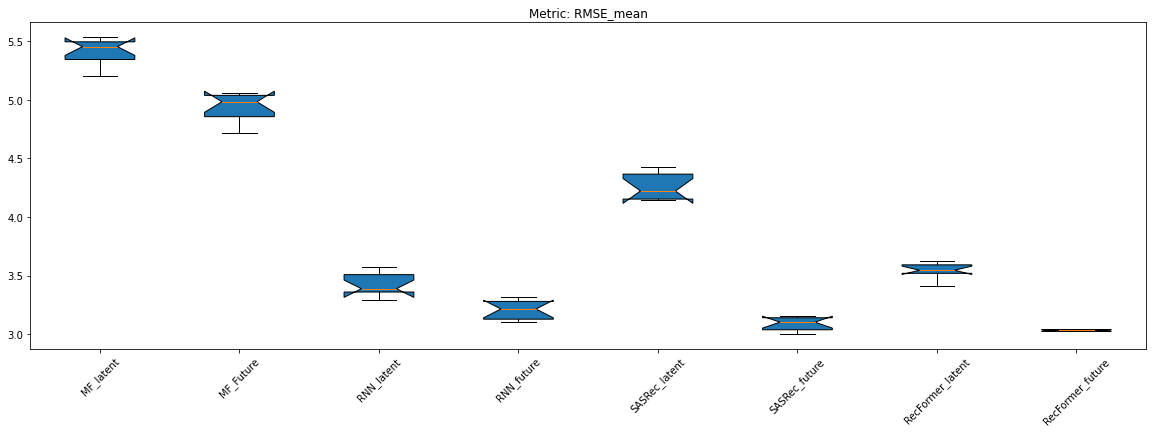

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 6))
    
vals = defaultdict(list)
    
for at_m, m in enumerate(all_methods):

    top_50 = get_best(".*{}.*".format(m), all_logs, 100)

    for result in top_50:
        if "RMSE_mean" not in result: continue
        if result["RMSE_mean"] > float(1e2): continue
        vals[m].append(result["RMSE_mean"])

p = ax

p.boxplot(
    vals.values(), 
    notch=True,  # notch shape
    vert=True,  # vertical box alignment
    patch_artist=True, 
    showfliers=False
)
p.set_xticklabels(vals.keys(), rotation = 45)
p.set_title("Metric: {}".format("RMSE_mean"))

fig.show()

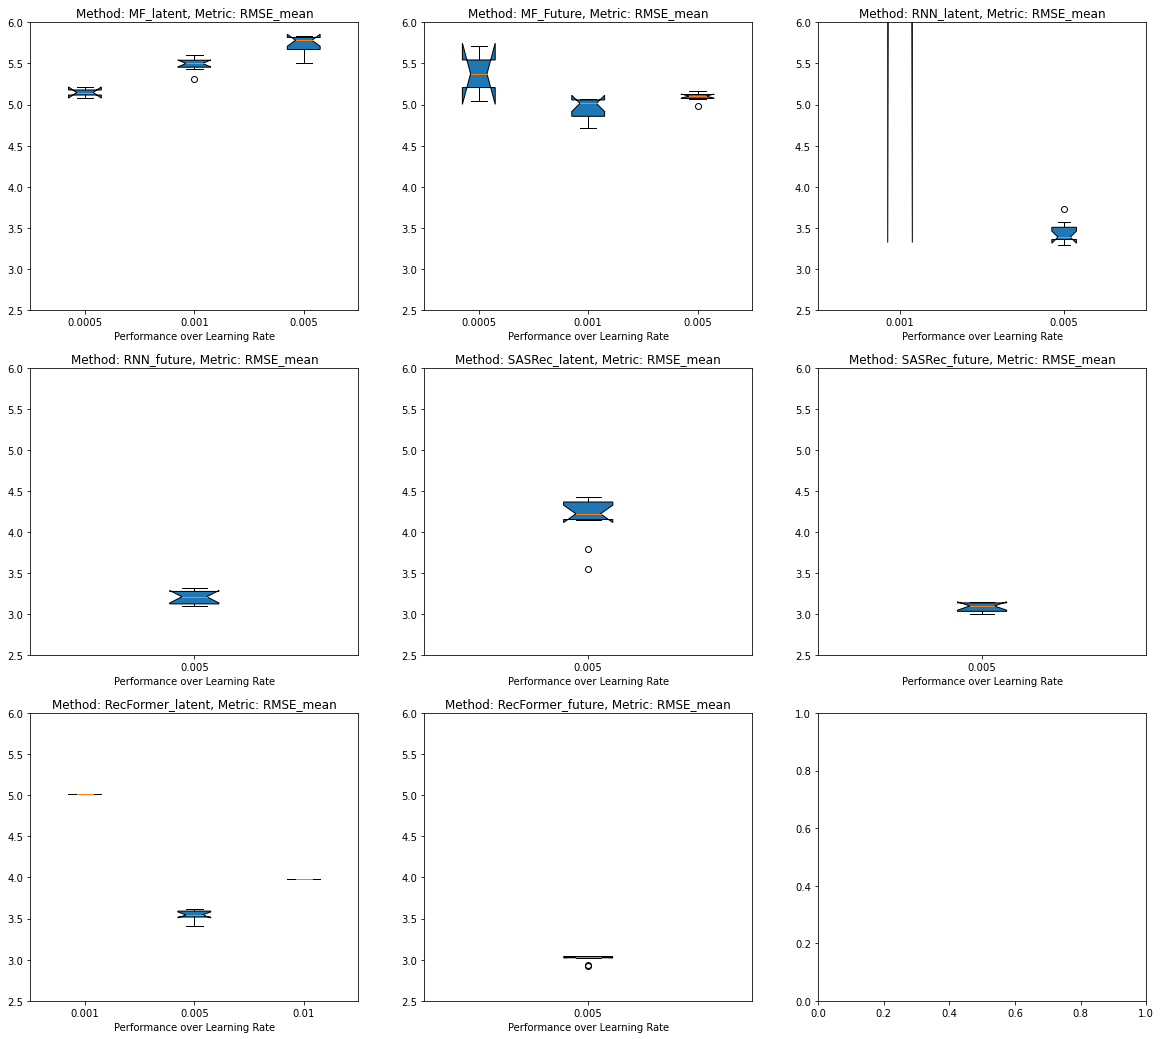

In [5]:
viz(".*{}.*lr_{}.*", [ 0.0001, 0.0005, 0.001, 0.005, 0.01 ], "Learning Rate", all_methods)

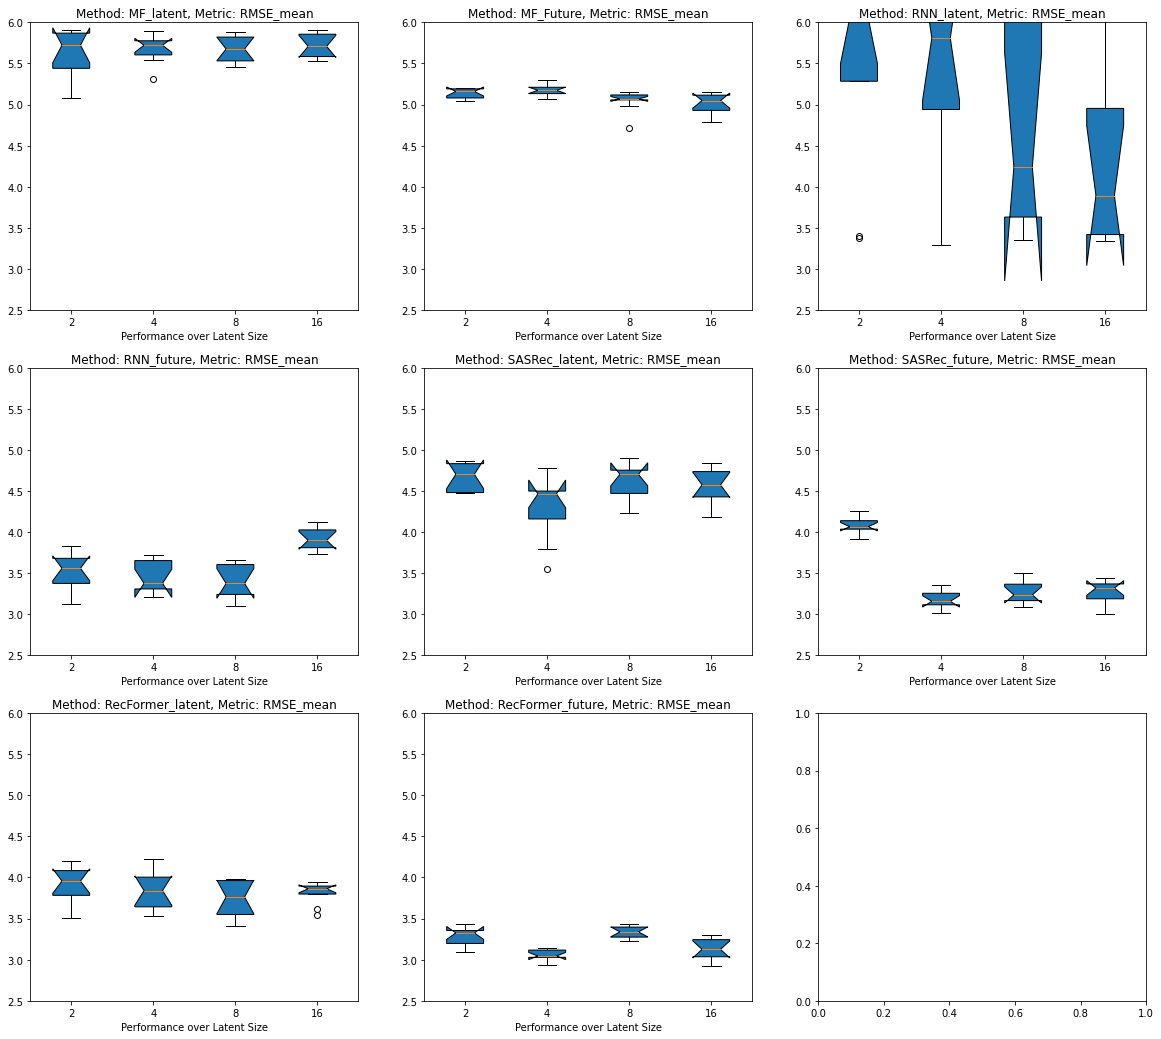

In [6]:
viz(".*{}.*_size_{}.*", [ 2, 4, 8, 16, 32 ], "Latent Size", all_methods)

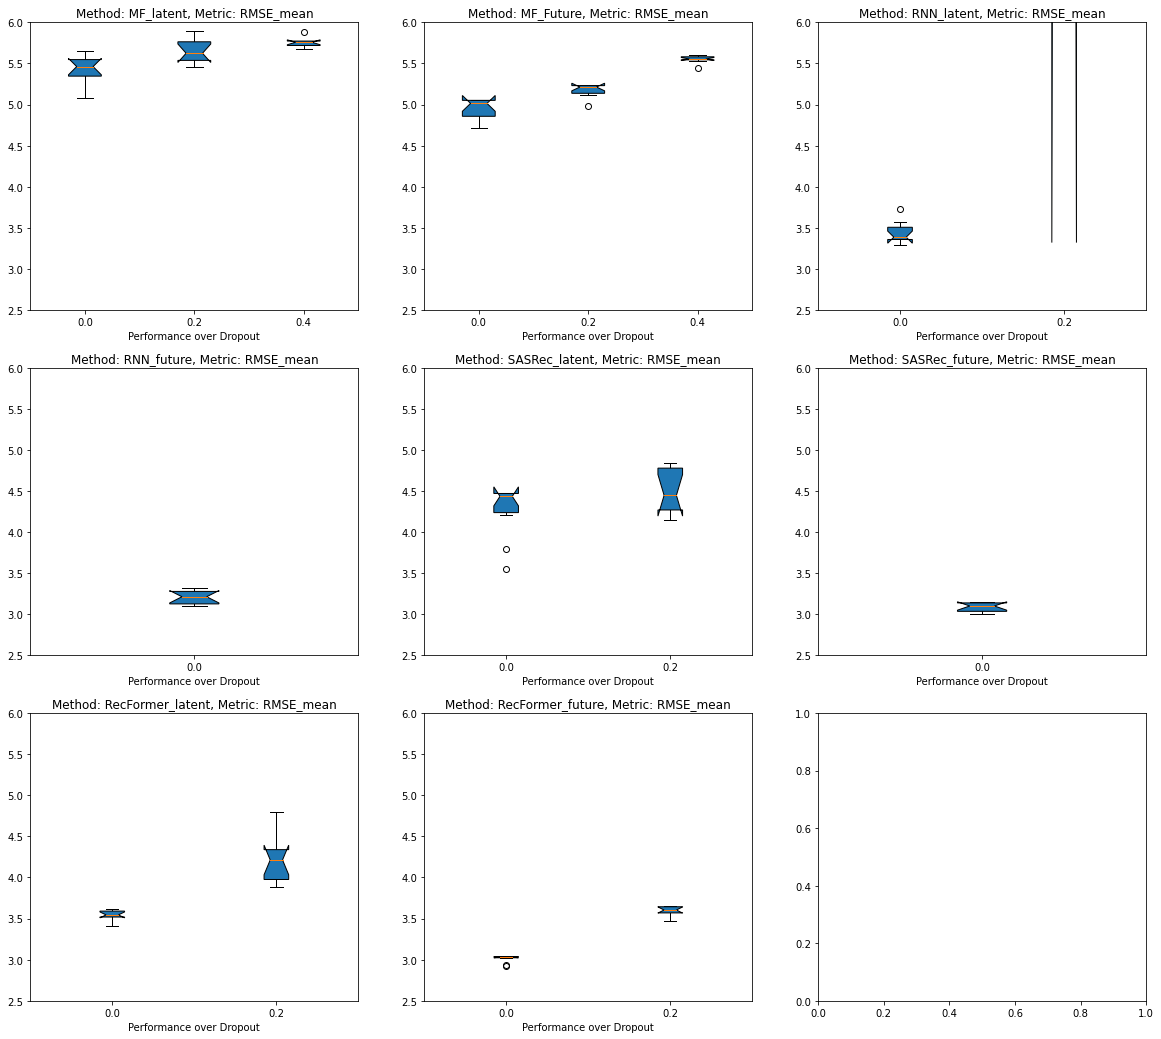

In [7]:
viz(".*{}.*dropout_{}.*", [ 0.0, 0.2, 0.4 ], "Dropout", all_methods)

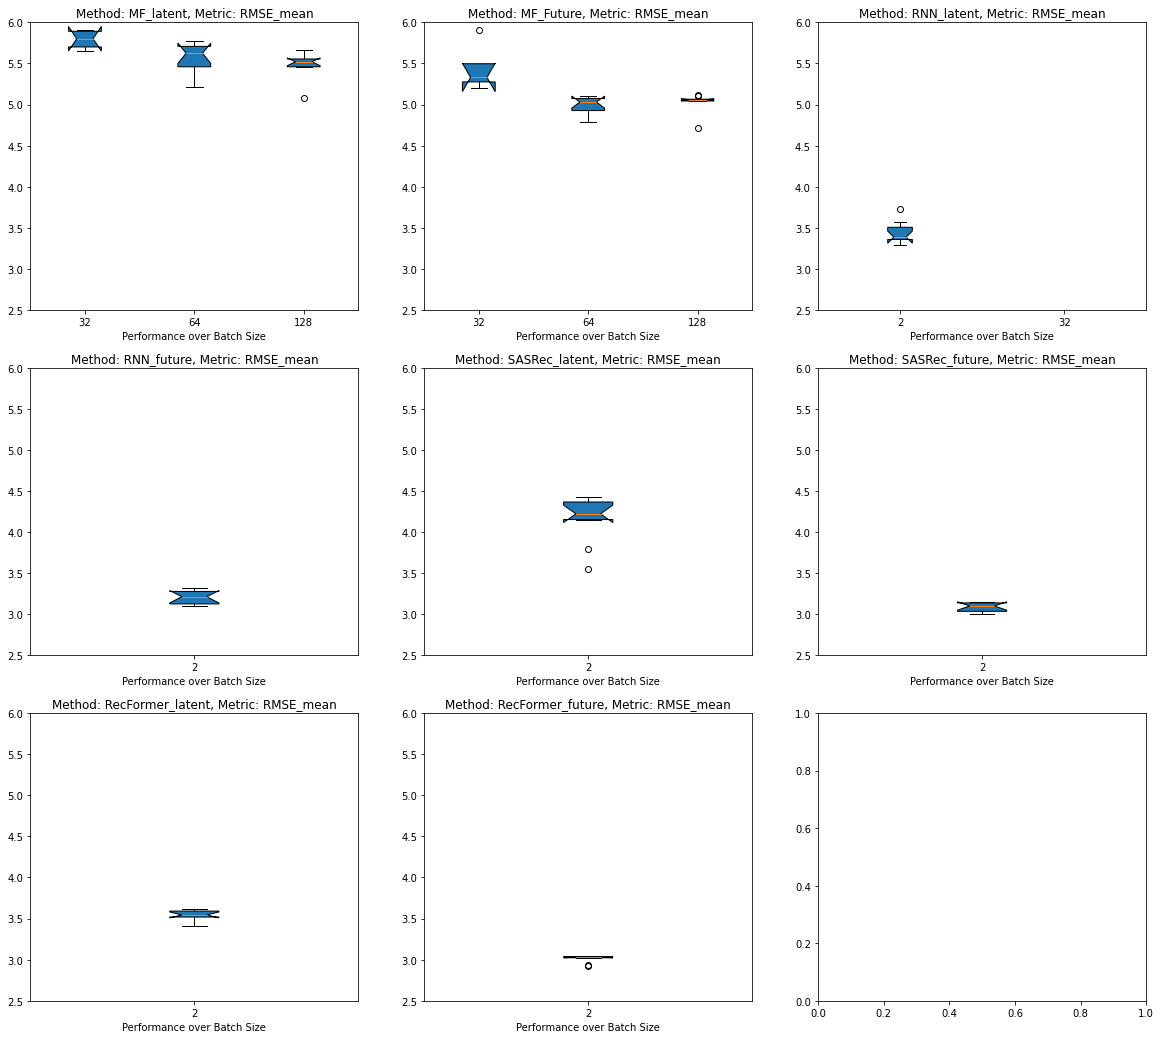

In [8]:
viz(".*{}.*bsz_{}_.*", [ 1, 2, 4, 8, 16, 32, 64, 128, 256 ], "Batch Size", all_methods)

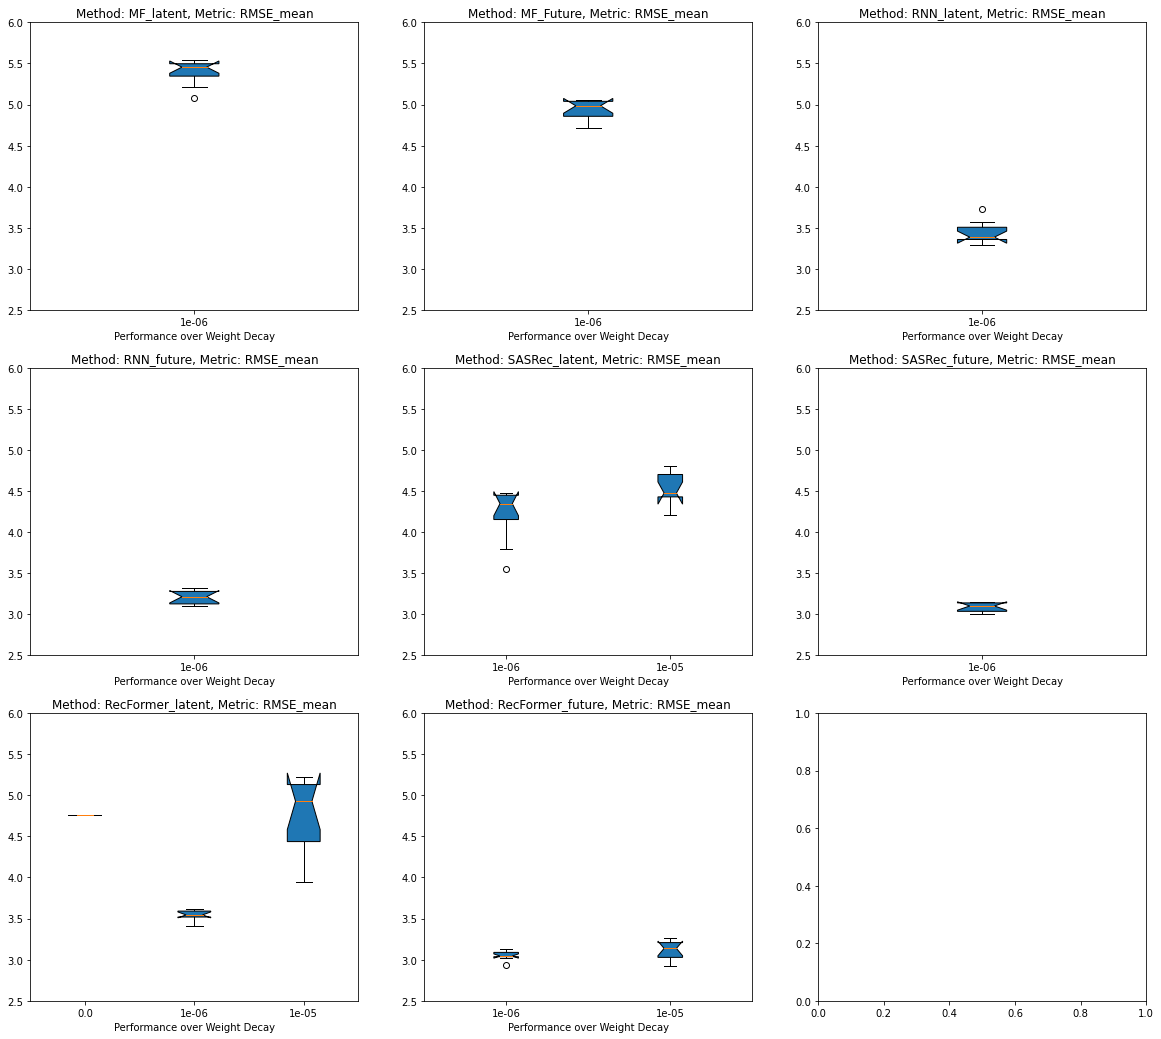

In [9]:
viz(".*{}.*wd_{}.*", [ 0.0, 1e-6, 1e-5 ], "Weight Decay", all_methods)

## Sequential methods stuff

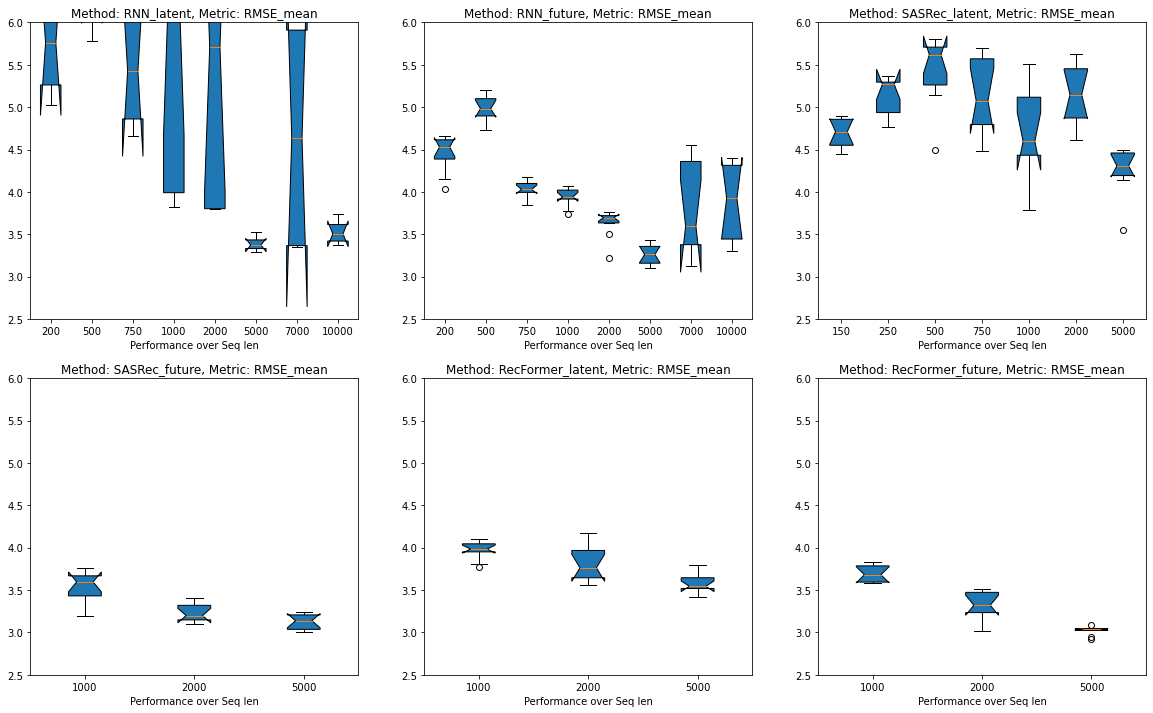

In [10]:
viz(".*{}.*max_seq_len_{}_.*", [ 100, 150, 200, 250, 500, 750, 1_000, 1_500, 2_000, 3_000, 5_000, 7_000, 10_000 ], "Seq len", sequential_methods)
# viz(".*{}.*max_seq_len_{}_.*", [ 100, 150, 250, 500, 1000 ], "Seq len", )

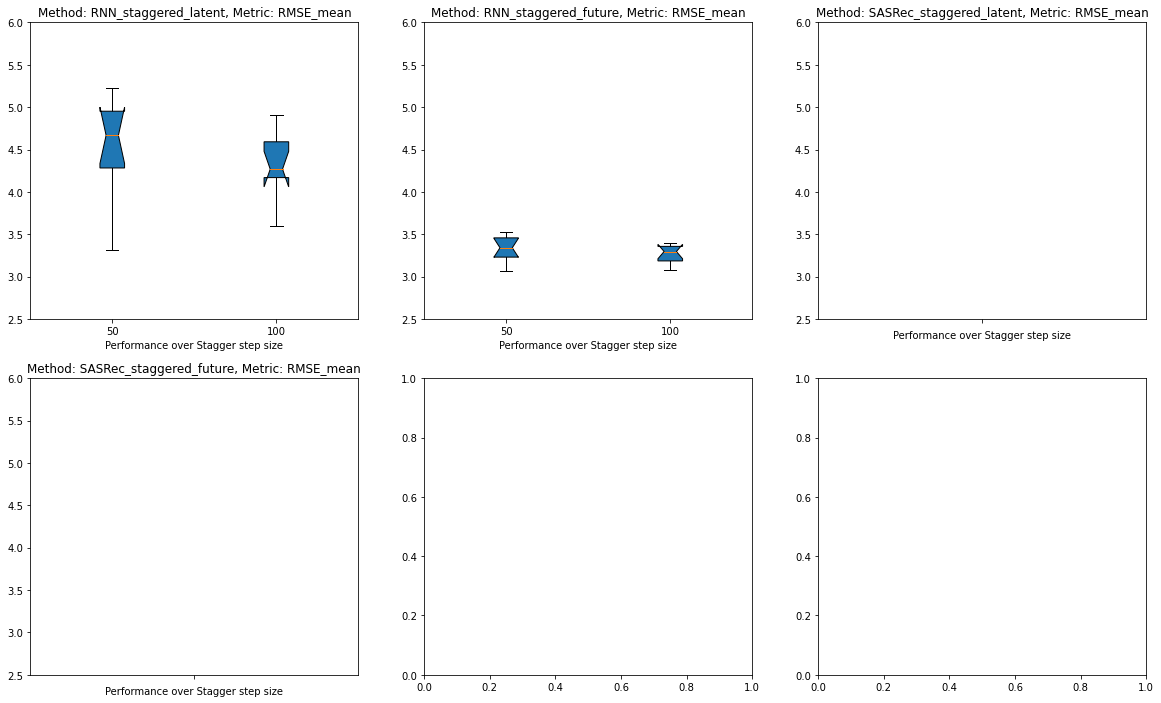

In [11]:
viz(".*{}.*seq_step_{}.*", [ 20, 35, 40, 50, 100 ], "Stagger step size", staggered_methods)

## SASRec stuff

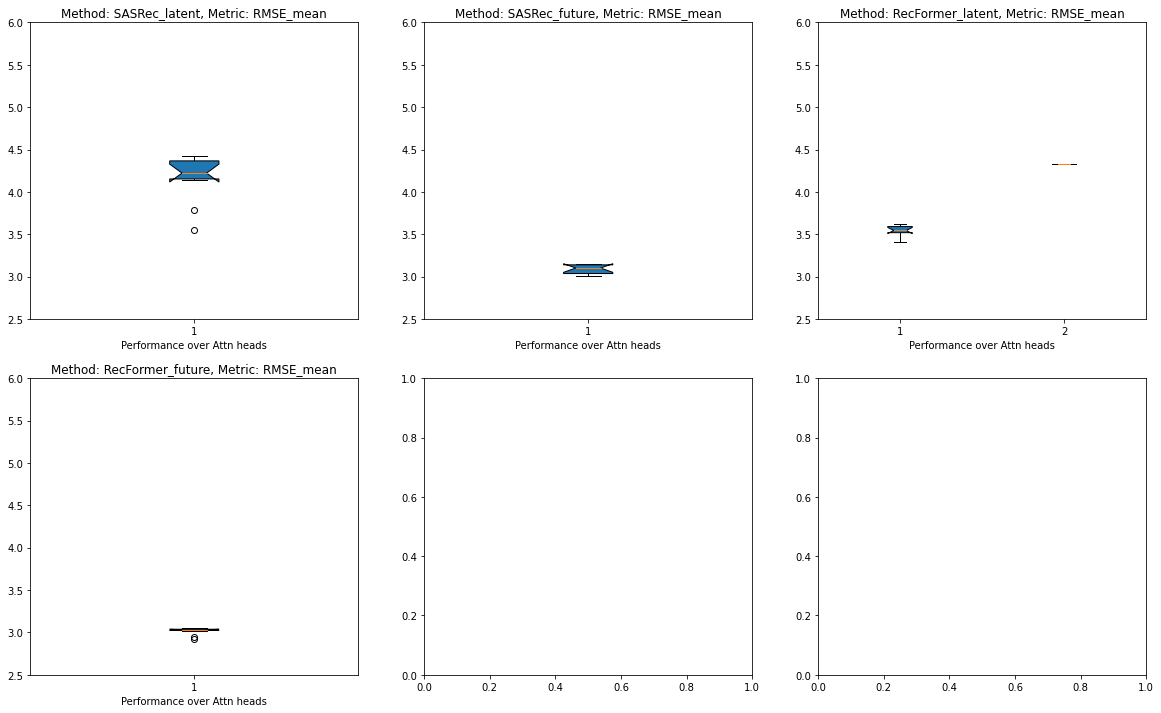

In [12]:
viz(".*{}.*heads_{}.*", [ 1, 2, 4 ], "Attn heads", sasrec_methods)

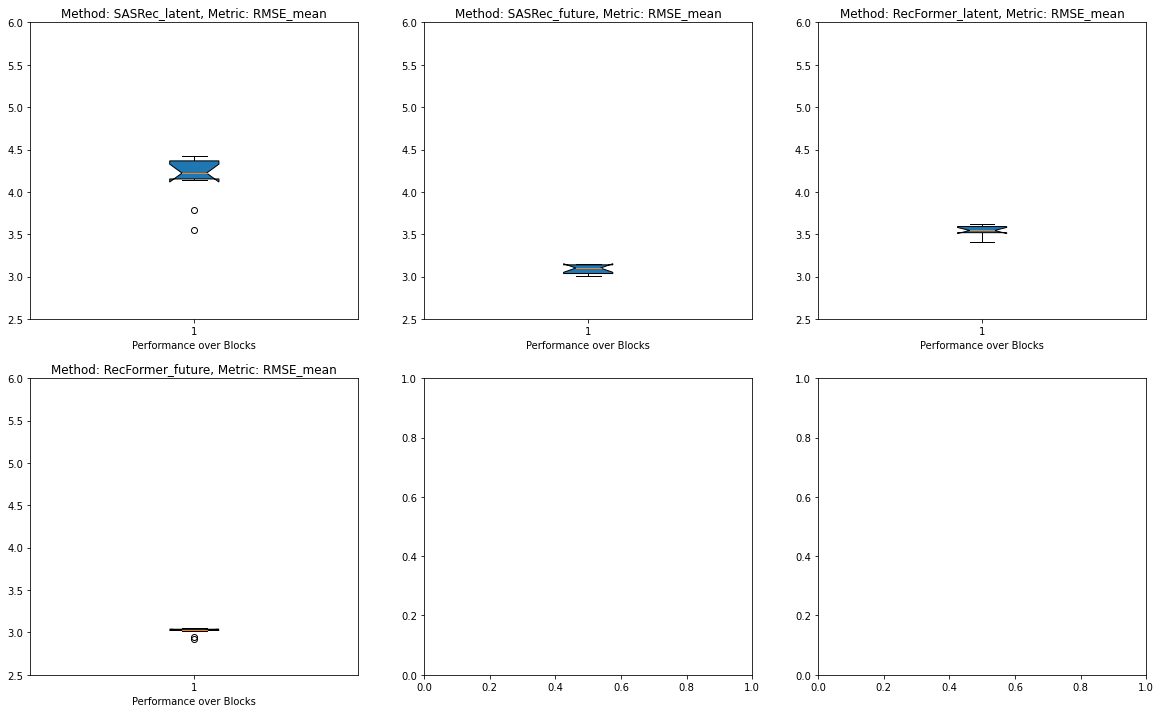

In [13]:
viz(".*{}.*blocks_{}.*", [ 1, 2, 4 ], "Blocks", sasrec_methods)

## RecFormer stuff

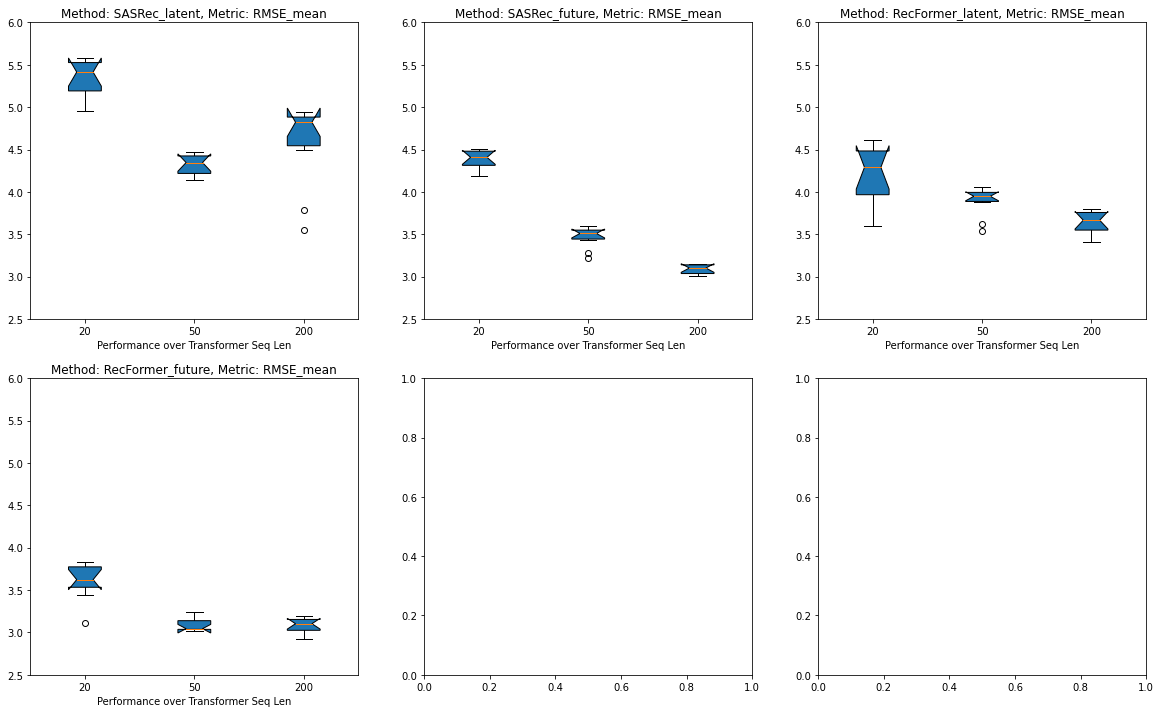

In [14]:
viz(".*{}.*transformer_len_{}_.*", [ 5, 10, 20, 50, 100, 200 ], "Transformer Seq Len", sasrec_methods)

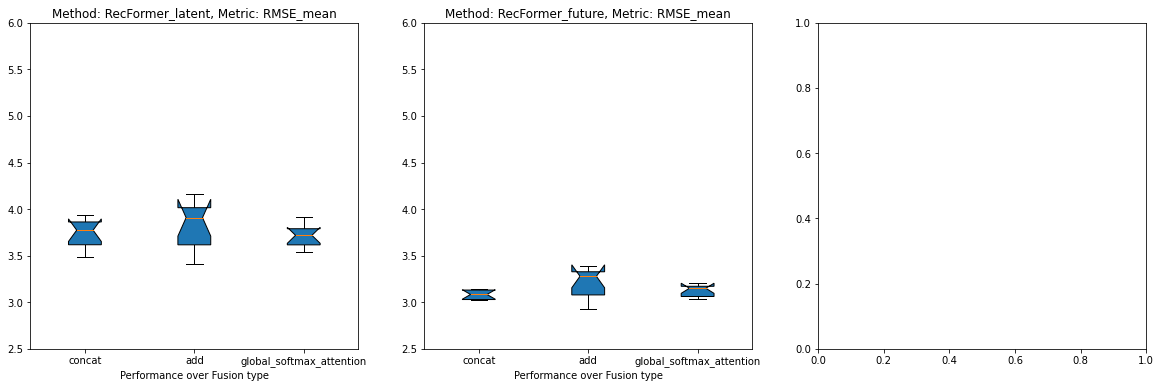

In [15]:
viz(".*{}.*fusion_{}_.*", [ 'concat', 'add', 'global_softmax_attention', 'global_raw_attention' ], "Fusion type", recformer_methods)

## Future models stuff

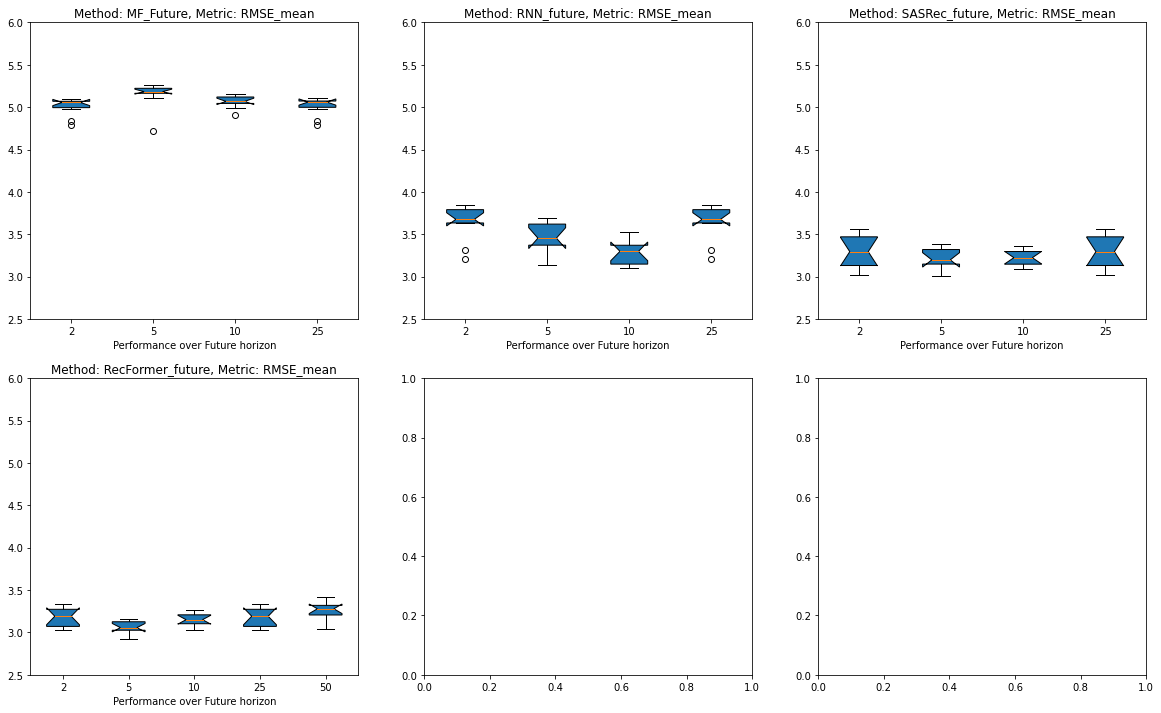

In [16]:
viz(".*{}.*train_K_{}.*", [ 2, 3, 5, 10, 15, 20, 25, 50, 100 ], "Future horizon", future_methods)

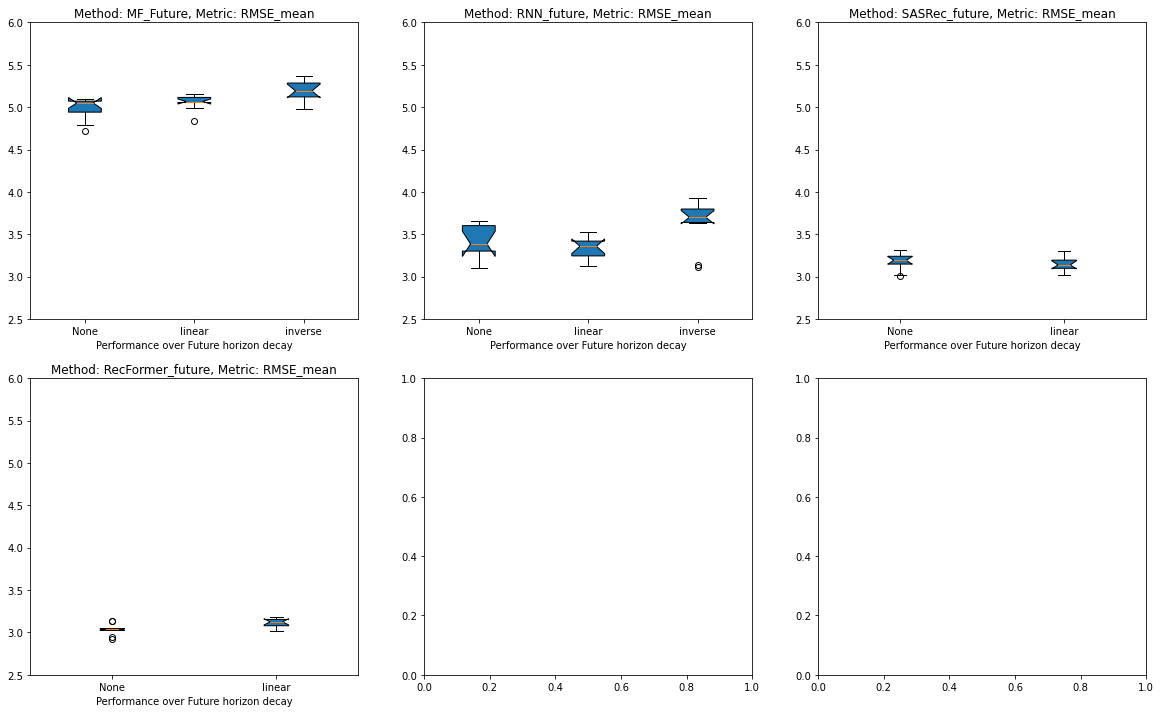

In [17]:
viz(".*{}.*decay_{}.*", [ 'None', 'linear', 'inverse' ], "Future horizon decay", [
    'MF_Future',
    'RNN_future',
#     'RNN_staggered_future',
    'SASRec_future',
#     'SASRec_staggered_future',
    'RecFormer_future'
])